In [1]:
import pybullet as p
import time
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PybulletConnection(object):

    def __init__(self , render):
        
        try : p.disconnect()
            
        except : pass
        
        if render:
            physicsClient = p.connect(p.GUI) 
        else : 
            physicsClient = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.createCollisionShape(p.GEOM_PLANE)
        p.createMultiBody(0, 0)
        p.setGravity(0,0,-9.8)
        startPos = [0,0,0]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        self.bodyObj = p.loadURDF("C://Users/antoz//Self Balancing Robot//balancebot_simple.xml" 
                               , startPos , startOrientation)
        
    def resetEnvironment(BalancingRobot):
        p.resetSimulation()
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.createCollisionShape(p.GEOM_PLANE)
        p.createMultiBody(0, 0)
        p.setGravity(0,0,-9.8)
        startPos = [0,0,0]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        bodyObj = p.loadURDF("C://Users/antoz//Self Balancing Robot//balancebot_simple.xml" 
                               , startPos , startOrientation) 
        return 0

In [13]:
class BalancingRobot(PybulletConnection):
    
    actions_dect = {0 : [35,-35] , 1:[25, -25] , 2:[12 , -12] , 3: [1,-1] , 4 :[5 , -5 ] ,
               4  : [-35 , 35] , 5:[-25 , 25] , 6:[-12, 12] , 7 : [-1 , 1] , 8 : [5 , -5] }    
    
    def __init__(self):
        self.reward = 0
        super().__init__(render=True)
        self.motor1 = MotorDC(0 , self.bodyObj)
        self.motor2 = MotorDC(1 , self.bodyObj)
        self.BASE_LINK_INDEX = 0
        
    def controlMotors(self, vel):
        
        self.motor1.currentVelocity = vel[0]
        self.motor2.currentVelocity = vel[1]
        
        p.setJointMotorControlArray(
                bodyIndex = self.bodyObj,
                jointIndices = [self.motor1.motor_index , self.motor2.motor_index],
                controlMode = p.VELOCITY_CONTROL,      
                targetVelocities=vel) 
              
    
    def isTerminalState(self):
        cubePos, _ = p.getBasePositionAndOrientation(self.bodyObj)
        
        return cubePos[2] < 0.15
    
    def read_State(self):
        x_orientation = p.getEulerFromQuaternion(p.getBasePositionAndOrientation(self.bodyObj)[1])[0]
    
        if x_orientation > 0 and x_orientation <= 0.25:
            return 0
    
        if x_orientation >= 0.25 and x_orientation <=0.5:
            return 1
        
        elif x_orientation > 0.5:
            return 2
    
        elif x_orientation < 0 and x_orientation >= -0.25:
            return 3
        
        elif x_orientation < -0.25 and x_orientation >= -0.5:
            return 4
        
        else : return 5
        
    def takeActionFromList(self,velocity):
        self.controlMotors(velocity)
        p.stepSimulation()
        time.sleep(0.01)
            
        if self.isTerminalState():
            self.reward -= 1000
        else :
            self.reward +=0.1
                
    def calculate_reward(self):
        return self.reward
    
    def step(self , action_index):
        
        velocity_list=BalancingRobot.actions_dect[action_index]
        self.takeActionFromList(velocity_list)
        new_state= self.read_State()
        r=self.calculate_reward()
        
        if self.isTerminalState():
            self.reward=0
            self.resetEnvironment()
            
        return (new_state , r)
    
    


#     def getLinearVelocity(self):
#         return p.getBaseVelocity(myRobot.bodyObj)[0]        
#     def moveRight(self):
#         self.controlMotors( vel=[ -5 , 5] )
        
#     def moveLeft(self):
#         self.controlMotors( vel= [5 , -5] )
        
#     def inverseMovement(self):
#         if(self.motor1.currentVelocity== -5):
#             self.moveLeft()
#         else :
#             self.moveRight()
            
        
#     def _isTerminalState(self):
#         '''
#         getContactPoints returns some tuples for each point , for each tuple we check if the linkindexA is BASE_CONTACT 
#         which is -1 for base links
#         '''
#         linkIndexA = 3
#         BASE_CONTACT = -1
#         p.performCollisionDetection()
#         for tup in p.getContactPoints(myRobot.bodyObj , self.BASE_LINK_INDEX ):
#             if tup[linkIndexA] == BASE_CONTACT :
#                 return True
#         return False
#     def _step(self, action):
#         self.theta_threshold_radians = 1
#         self.x_threshold = 2.4
#         p.stepSimulation()
#         time.sleep(0.0001)
#         self.state = p.getJointState(self.bodyObj, 1)[0:2] + p.getJointState(self.bodyObj, 0)[0:2]
        
#         theta, theta_dot, x, x_dot = self.state
#         dv = 0.1
        
#         deltav = [-10.*dv , -5.*dv , -2.*dv , -0.1*dv , 0 , 0.1*dv , 2.*dv , 5.*dv , 10.*dv][action]

#         p.setJointMotorControlArray(self.bodyObj, [0,1], p.VELOCITY_CONTROL, targetVelocities=[(deltav + self.state[3]) , -(deltav + self.state[3])])
#         done =  x < -self.x_threshold \
#                 or x > self.x_threshold \
#                 or theta < -self.theta_threshold_radians \
#                 or theta > self.theta_threshold_radians
#         self.reward += 1.0
#         r= self.reward
#         if done:
#             r = self.reward - 1000
#             self.reward=0
#             self.resetEnvironment()
#         return self.read_State() , r, done, {}



In [8]:
class MotorDC(object):
    
    def __init__(self , motor_index , bodyObj):
        
        self.motor_index=motor_index
        self.bodyObj= bodyObj
        self.currentVelocity = 0

In [9]:
class QLearning(object):
    def __init__(self , lr , dr , epsilon , n_states , n_actions):
        self.lr=lr
        self.discount_rate=dr
        self.epsilon=epsilon
        self.Q_table=np.zeros((n_states,n_actions))
        self.n_states=n_states
        self.n_actions=n_actions
        self.train_rewards=[]
        self.test_rewards = []
        self.decay_rate=0.008
        
    def exponential_decay_epsilon(self, state ):

        if np.random.rand(1) > self.epsilon:
            return np.argmax(self.Q_table[state, :])
        else :
            return np.random.randint(0, self.n_actions)
    
    def epsilon_greedy(self,state):
        if  np.random.rand(1) < self.epsilon:
            action = np.argmax(self.Q_table[state, :])
        else:
            action = np.random.randint(0, self.n_actions)

        return action
    
    def train(self , myRobot ,episodes , steps):
        old_state = myRobot.resetEnvironment()
        print(old_state)
        
        for episode in range(episodes):
                self.epsilon=np.exp(-self.decay_rate * episode)
                print("episode num :" ,episode)
                print("epsilon :" ,self.epsilon)
                print("average reward :" ,np.average(self.train_rewards))
                for step in range(steps):
                    action = self.exponential_decay_epsilon(old_state) 
                    new_state , reward  = myRobot.step(action)
                    self.Q_table[old_state,action] += self.lr * ( myRobot.reward + (self.discount_rate * np.max(self.Q_table[new_state , :])) - self.Q_table[old_state,action])
                    self.train_rewards.append(myRobot.reward)
                    old_state =new_state
    def test(self , myRobot):
        old_state = myRobot.resetEnvironment()
        self.epsilon=1
        for i in range(5000):
                action = self.epsilon_greedy(old_state) 
                new_state, reward = myRobot.step(action)
                self.test_rewards.append(myRobot.reward)
                old_state = new_state
    def plot_statistics(self):
        print("Train Rewards :")
        plt.plot(self.train_rewards)
        plt.hist(self.train_rewards)
        print("Test Rewards :")
        plt.plot(self.test_rewards)
        plt.hist(self.test_rewards)

In [10]:
agent = QLearning(0.8, 0.9, 0.7 , n_states = 6,  n_actions=7)
myRobot = BalancingRobot()
agent.train(myRobot , episodes = 2000 , steps =1000)

0
episode num : 0
epsilon : 1.0
average reward : nan
episode num : 1
epsilon : 0.9920319148370607
average reward : 8.880499999999989
episode num : 2
epsilon : 0.9841273200552851
average reward : 8.43089999999999
episode num : 3
epsilon : 0.9762857097579093
average reward : 8.597766666666658
episode num : 4
epsilon : 0.9685065820791976
average reward : 8.69182499999999
episode num : 5
epsilon : 0.9607894391523232
average reward : 8.80667999999999
episode num : 6
epsilon : 0.9531337870775047
average reward : 8.409333333333326
episode num : 7
epsilon : 0.9455391358903963
average reward : 8.121699999999992
episode num : 8
epsilon : 0.9380049995307295
average reward : 8.153699999999992
episode num : 9
epsilon : 0.9305308958112057
average reward : 8.11728888888888
episode num : 10
epsilon : 0.9231163463866358
average reward : 7.998819999999991
episode num : 11
epsilon : 0.9157608767233256
average reward : 8.036963636363627
episode num : 12
epsilon : 0.9084640160687062
average reward : 8.1133

episode num : 102
epsilon : 0.44219690927989863
average reward : 8.78745784313725
episode num : 103
epsilon : 0.4386734466479678
average reward : 8.77163398058252
episode num : 104
epsilon : 0.43517805926635666
average reward : 8.780196153846148
episode num : 105
epsilon : 0.43171052342907973
average reward : 8.779932380952376
episode num : 106
epsilon : 0.4282706172126597
average reward : 8.77480943396226
episode num : 107
epsilon : 0.42485812046192456
average reward : 8.771727102803734
episode num : 108
epsilon : 0.42147281477591764
average reward : 8.746039814814809
episode num : 109
epsilon : 0.41811448349391933
average reward : 8.749959633027517
episode num : 110
epsilon : 0.4147829116815814
average reward : 8.84988545454545
episode num : 111
epsilon : 0.41147788611717057
average reward : 8.87546396396396
episode num : 112
epsilon : 0.4081991952779227
average reward : 8.870066071428568
episode num : 113
epsilon : 0.4049466293265049
average reward : 8.886928318584067
episode num : 

episode num : 203
epsilon : 0.19710868536806264
average reward : 8.961478817733987
episode num : 204
epsilon : 0.1955381065766949
average reward : 8.959709803921566
episode num : 205
epsilon : 0.19398004229089189
average reward : 8.95344146341463
episode num : 206
epsilon : 0.19243439279400748
average reward : 8.939657766990289
episode num : 207
epsilon : 0.19090105916394629
average reward : 8.982445410628015
episode num : 208
epsilon : 0.18937994326683263
average reward : 8.973817307692304
episode num : 209
epsilon : 0.18787094775072993
average reward : 8.963015789473681
episode num : 210
epsilon : 0.18637397603940997
average reward : 9.041187619047616
episode num : 211
epsilon : 0.18488893232617234
average reward : 9.034363507109003
episode num : 212
epsilon : 0.18341572156771246
average reward : 9.028458962264148
episode num : 213
epsilon : 0.18195424947803895
average reward : 9.021007511737086
episode num : 214
epsilon : 0.18050442252243923
average reward : 9.014366822429903
episod

episode num : 302
epsilon : 0.08927801625161007
average reward : 15.885906291390627
episode num : 303
epsilon : 0.08856664141493896
average reward : 15.98456402640254
episode num : 304
epsilon : 0.0878609348735492
average reward : 15.982047697368323
episode num : 305
epsilon : 0.0871608514619813
average reward : 16.24522131147531
episode num : 306
epsilon : 0.08646634637465792
average reward : 16.384500653594664
episode num : 307
epsilon : 0.08577737516301644
average reward : 16.366729315960804
episode num : 308
epsilon : 0.08509389373266411
average reward : 16.341348701298593
episode num : 309
epsilon : 0.08441585834055614
average reward : 16.41333818770216
episode num : 310
epsilon : 0.08374322559219596
average reward : 16.798617741935367
episode num : 311
epsilon : 0.0830759524388581
average reward : 17.5029630225079
episode num : 312
epsilon : 0.08241399617483297
average reward : 17.910461538461398
episode num : 313
epsilon : 0.08175731443469375
average reward : 17.884932587859286


episode num : 401
epsilon : 0.04043740726563748
average reward : 146.396231421418
episode num : 402
epsilon : 0.040115198560776416
average reward : 146.45581791041943
episode num : 403
epsilon : 0.039795557242315927
average reward : 146.76324764265163
episode num : 404
epsilon : 0.039478462853102525
average reward : 147.31668019799164
episode num : 405
epsilon : 0.039163895098987066
average reward : 148.11429333330534
episode num : 406
epsilon : 0.03885183384752591
average reward : 149.15428275859293
episode num : 407
epsilon : 0.03854225912669246
average reward : 150.43486191643441
episode num : 408
epsilon : 0.03823515112359889
average reward : 151.42215563722766
episode num : 409
epsilon : 0.0379304901832282
average reward : 151.06555012222222
episode num : 410
epsilon : 0.0376282568071762
average reward : 150.73626487802167
episode num : 411
epsilon : 0.03732843165240367
average reward : 150.60272165447418
episode num : 412
epsilon : 0.037030995529998355
average reward : 150.712545

episode num : 499
epsilon : 0.018462751666353888
average reward : 925.7164701407855
episode num : 500
epsilon : 0.01831563888873418
average reward : 941.8567372005343
episode num : 501
epsilon : 0.0181696983182551
average reward : 958.1321728548558
episode num : 502
epsilon : 0.01802492061467033
average reward : 974.5419693233041
episode num : 503
epsilon : 0.017881296512157415
average reward : 991.085325249135
episode num : 504
epsilon : 0.017738816818724773
average reward : 1007.7614456355784
episode num : 505
epsilon : 0.017597472415623393
average reward : 1024.5695417828686
episode num : 506
epsilon : 0.01745725425676323
average reward : 1041.5088312260198
episode num : 507
epsilon : 0.017318153368134255
average reward : 1058.5785376733406
episode num : 508
epsilon : 0.017180160847232114
average reward : 1075.7778909456727
episode num : 509
epsilon : 0.017043267862488373
average reward : 1093.1061269163463
episode num : 510
epsilon : 0.01690746565270528
average reward : 1110.562487

episode num : 597
epsilon : 0.008429650221000132
average reward : 3046.609411395247
episode num : 598
epsilon : 0.008362482050145411
average reward : 3072.9459341186785
episode num : 599
epsilon : 0.008295849080996301
average reward : 3099.36146678293
episode num : 600
epsilon : 0.00822974704902003
average reward : 3125.8556143382984
episode num : 601
epsilon : 0.00816417172366399
average reward : 3152.4279843643626
episode num : 602
epsilon : 0.008099118908084974
average reward : 3179.0781870481446
episode num : 603
epsilon : 0.00803458443888058
average reward : 3205.8058351624923
episode num : 604
epsilon : 0.007970564185822752
average reward : 3232.6105440446704
episode num : 605
epsilon : 0.007907054051593441
average reward : 3259.49193157517
episode num : 606
epsilon : 0.00784404997152238
average reward : 3286.449618156721
episode num : 607
epsilon : 0.007781547913326937
average reward : 3313.4832266935205
episode num : 608
epsilon : 0.007719543876854055
average reward : 3340.5923

episode num : 695
epsilon : 0.0038487763976105395
average reward : 5951.250530355009
episode num : 696
epsilon : 0.0038181090195012674
average reward : 5983.785874420396
episode num : 697
epsilon : 0.0037876860016724944
average reward : 6016.371332276124
episode num : 698
epsilon : 0.0037575053970406946
average reward : 6049.00668853341
episode num : 699
epsilon : 0.00372756527403687
average reward : 6081.6917290360225
episode num : 700
epsilon : 0.003697863716482929
average reward : 6114.426240851483
episode num : 701
epsilon : 0.0036683988234690493
average reward : 6147.210012262333
episode num : 702
epsilon : 0.0036391687092320216
average reward : 6180.04283275748
episode num : 703
epsilon : 0.0036101715030345564
average reward : 6212.924493023622
episode num : 704
epsilon : 0.0035814053490455635
average reward : 6245.8547849367305
episode num : 705
epsilon : 0.003552868406221362
average reward : 6278.83350155363
episode num : 706
epsilon : 0.0035245588481878734
average reward : 631

average reward : 9312.520919920204
episode num : 793
epsilon : 0.0017572591235044724
average reward : 9349.069884711884
episode num : 794
epsilon : 0.0017432571331550365
average reward : 9385.65273120434
episode num : 795
epsilon : 0.0017293667118571557
average reward : 9422.269331542095
episode num : 796
epsilon : 0.0017155869706191255
average reward : 9458.919558512167
episode num : 797
epsilon : 0.0017019170275328031
average reward : 9495.603285540028
episode num : 798
epsilon : 0.001688356007717165
average reward : 9532.320386685611
episode num : 799
epsilon : 0.0016749030432623145
average reward : 9569.07073663934
episode num : 800
epsilon : 0.001661557273173934
average reward : 9605.854210718182
episode num : 801
epsilon : 0.0016483178433181827
average reward : 9642.670684861745
episode num : 802
epsilon : 0.0016351839063670308
average reward : 9679.52003562839
episode num : 803
epsilon : 0.0016221546217440304
average reward : 9716.402140191378
episode num : 804
epsilon : 0.00160

average reward : 13037.98861634018
episode num : 891
epsilon : 0.0008023224287742007
average reward : 13077.335262112616
episode num : 892
epsilon : 0.0007959294553335915
average reward : 13116.705794329506
episode num : 893
epsilon : 0.0007895874216498015
average reward : 13156.10013274524
episode num : 894
epsilon : 0.0007832959218305102
average reward : 13195.518197473239
episode num : 895
epsilon : 0.0007770545532175816
average reward : 13234.959908983967
episode num : 896
epsilon : 0.000770862916361294
average reward : 13274.425188102927
episode num : 897
epsilon : 0.0007647206149947755
average reward : 13313.91395600869
episode num : 898
epsilon : 0.0007586272560086417
average reward : 13353.42613423092
episode num : 899
epsilon : 0.0007525824494258378
average reward : 13392.961644648425
episode num : 900
epsilon : 0.0007465858083766792
average reward : 13432.520409487224
episode num : 901
epsilon : 0.0007406369490740919
average reward : 13472.102351318608
episode num : 902
epsil

average reward : 16955.123929579844
episode num : 988
epsilon : 0.0003692635282949294
average reward : 16996.46069685703
episode num : 989
epsilon : 0.0003663212050539079
average reward : 17037.8149833106
episode num : 990
epsilon : 0.0003634023264950478
average reward : 17079.18673585214
episode num : 991
epsilon : 0.000360506705809125
average reward : 17120.575901607524
episode num : 992
epsilon : 0.00035763415767542714
average reward : 17161.982427915817
episode num : 993
epsilon : 0.00035478449824989324
average reward : 17203.40626232822
episode num : 994
epsilon : 0.00035195754515334734
average reward : 17244.847352606994
episode num : 995
epsilon : 0.0003491531174598264
average reward : 17286.305646724402
episode num : 996
epsilon : 0.00034637103568500074
average reward : 17327.781092861653
episode num : 997
epsilon : 0.00034361112177468714
average reward : 17369.27363940786
episode num : 998
epsilon : 0.0003408731990934533
average reward : 17410.783234958977
episode num : 999
ep

average reward : 20996.407126903094
episode num : 1084
epsilon : 0.0001713161291055253
average reward : 21039.211040992144
episode num : 1085
epsilon : 0.0001699510675990275
average reward : 21082.02821975569
episode num : 1086
epsilon : 0.00016859688301886584
average reward : 21124.858626550988
episode num : 1087
epsilon : 0.00016725348869676556
average reward : 21167.70222487012
episode num : 1088
epsilon : 0.00016592079865503085
average reward : 21210.558978339413
episode num : 1089
epsilon : 0.0001645987276010448
average reward : 21253.428850718778
episode num : 1090
epsilon : 0.00016328719092180806
average reward : 21296.311805901118
episode num : 1091
epsilon : 0.0001619861046785261
average reward : 21339.207807911727
episode num : 1092
epsilon : 0.00016069538560123465
average reward : 21382.11682090767
episode num : 1093
epsilon : 0.00015941495108347278
average reward : 21425.038809177182
episode num : 1094
epsilon : 0.0001581447191769937
average reward : 21467.973737139084
epis

episode num : 1178
epsilon : 8.076232305601659e-05
average reward : 25117.329939226125
episode num : 1179
epsilon : 8.011880198794935e-05
average reward : 25161.247259040174
episode num : 1180
epsilon : 7.948040855055677e-05
average reward : 25205.17488848166
episode num : 1181
epsilon : 7.884710188644065e-05
average reward : 25249.11280136186
episode num : 1182
epsilon : 7.82188414637586e-05
average reward : 25293.06097158068
episode num : 1183
epsilon : 7.759558707362885e-05
average reward : 25337.019373126266
episode num : 1184
epsilon : 7.697729882755796e-05
average reward : 25380.987980074653
episode num : 1185
epsilon : 7.636393715488688e-05
average reward : 25424.96676658938
episode num : 1186
epsilon : 7.575546280025946e-05
average reward : 25468.955706921115
episode num : 1187
epsilon : 7.515183682110904e-05
average reward : 25512.95477540731
episode num : 1188
epsilon : 7.455302058516719e-05
average reward : 25556.963946471817
episode num : 1189
epsilon : 7.395897576799013e-0

episode num : 1273
epsilon : 3.776982706062723e-05
average reward : 29332.144869154152
episode num : 1274
epsilon : 3.74688738620187e-05
average reward : 29376.935846494325
episode num : 1275
epsilon : 3.7170318684126666e-05
average reward : 29421.734994850445
episode num : 1276
epsilon : 3.687414241931798e-05
average reward : 29466.54229501166
episode num : 1277
epsilon : 3.658032611221046e-05
average reward : 29511.357727827275
episode num : 1278
epsilon : 3.628885095846031e-05
average reward : 29556.18127420657
episode num : 1279
epsilon : 3.599969830355805e-05
average reward : 29601.0129151185
episode num : 1280
epsilon : 3.571284964163521e-05
average reward : 29645.852631591515
episode num : 1281
epsilon : 3.542828661427944e-05
average reward : 29690.700404713287
episode num : 1282
epsilon : 3.514599100935981e-05
average reward : 29735.556215630506
episode num : 1283
epsilon : 3.486594475986136e-05
average reward : 29780.42004554864
episode num : 1284
epsilon : 3.458812994272841e-

average reward : 33575.80857242834
episode num : 1368
epsilon : 1.7663680070225723e-05
average reward : 33621.291058852796
episode num : 1369
epsilon : 1.7522934363135267e-05
average reward : 33666.78014500491
episode num : 1370
epsilon : 1.738331012982519e-05
average reward : 33712.27581643272
episode num : 1371
epsilon : 1.7244798434296973e-05
average reward : 33757.77805872642
episode num : 1372
epsilon : 1.7107390411754758e-05
average reward : 33803.28685751825
episode num : 1373
epsilon : 1.6971077268038258e-05
average reward : 33848.80219848226
episode num : 1374
epsilon : 1.683585027905969e-05
average reward : 33894.32406733426
episode num : 1375
epsilon : 1.670170079024566e-05
average reward : 33939.85244983157
episode num : 1376
epsilon : 1.6568620215983034e-05
average reward : 33985.38733177292
episode num : 1377
epsilon : 1.6436600039069697e-05
average reward : 34030.92869899831
episode num : 1378
epsilon : 1.6305631810169203e-05
average reward : 34076.476537388844
episode n

episode num : 1463
epsilon : 8.260710146288608e-06
average reward : 37970.28839278233
episode num : 1464
epsilon : 8.194888104336631e-06
average reward : 38016.34410426379
episode num : 1465
epsilon : 8.12959053802051e-06
average reward : 38062.40520043948
episode num : 1466
epsilon : 8.064813268273744e-06
average reward : 38108.47167029025
episode num : 1467
epsilon : 8.000552149328928e-06
average reward : 38154.54350282697
episode num : 1468
epsilon : 7.936803068452546e-06
average reward : 38200.62068709049
episode num : 1469
epsilon : 7.87356194568163e-06
average reward : 38246.70321215148
episode num : 1470
epsilon : 7.810824733562767e-06
average reward : 38292.79106711034
episode num : 1471
epsilon : 7.748587416892939e-06
average reward : 38338.884241097134
episode num : 1472
epsilon : 7.686846012462662e-06
average reward : 38384.98272327145
episode num : 1473
epsilon : 7.6255965688009515e-06
average reward : 38431.08650282232
episode num : 1474
epsilon : 7.5648351659225345e-06
av

average reward : 46759.653492164194
episode num : 1653
epsilon : 1.8067155036600883e-06
average reward : 46806.55984214035
episode num : 1654
epsilon : 1.7923194406617203e-06
average reward : 46853.46993292669
episode num : 1655
epsilon : 1.7780380867193375e-06
average reward : 46900.383757742304
episode num : 1656
epsilon : 1.7638705278214065e-06
average reward : 46947.30130982263
episode num : 1657
epsilon : 1.7498158572393283e-06
average reward : 46994.22258241946
episode num : 1658
epsilon : 1.735873175469382e-06
average reward : 47041.14756880086
episode num : 1659
epsilon : 1.7220415901751813e-06
average reward : 47088.07626225112
episode num : 1660
epsilon : 1.7083202161305406e-06
average reward : 47135.00865607072
episode num : 1661
epsilon : 1.6947081751628429e-06
average reward : 47181.94474357627
episode num : 1662
epsilon : 1.6812045960968142e-06
average reward : 47228.884518100465
episode num : 1663
epsilon : 1.6678086146987912e-06
average reward : 47275.827972992054
episo

episode num : 1748
epsilon : 8.449401842201223e-07
average reward : 51278.80387262329
episode num : 1749
epsilon : 8.382076288746659e-07
average reward : 51326.040605688286
episode num : 1750
epsilon : 8.315287191035679e-07
average reward : 51373.28049677264
episode num : 1751
epsilon : 8.2490302745432e-07
average reward : 51420.52354046571
episode num : 1752
epsilon : 8.183301298803982e-07
average reward : 51467.76973136917
episode num : 1753
epsilon : 8.118096057141113e-07
average reward : 51515.01906409704
episode num : 1754
epsilon : 8.053410376396897e-07
average reward : 51562.27153327562
episode num : 1755
epsilon : 7.98924011666566e-07
average reward : 51609.52713354346
episode num : 1756
epsilon : 7.925581171028903e-07
average reward : 51656.785859551324
episode num : 1757
epsilon : 7.862429465292349e-07
average reward : 51704.04770596213
episode num : 1758
epsilon : 7.799780957725303e-07
average reward : 51751.312667450984
episode num : 1759
epsilon : 7.737631638801868e-07
ave

average reward : 55827.196729766496
episode num : 1845
epsilon : 3.888780650192921e-07
average reward : 55874.71361500992
episode num : 1846
epsilon : 3.8577945147921897e-07
average reward : 55922.233190518506
episode num : 1847
epsilon : 3.8270552795572087e-07
average reward : 55969.755451922596
episode num : 1848
epsilon : 3.796560977166417e-07
average reward : 56017.28039486197
episode num : 1849
epsilon : 3.766309655974066e-07
average reward : 56064.808014985836
episode num : 1850
epsilon : 3.73629937988526e-07
average reward : 56112.338307952814
episode num : 1851
epsilon : 3.7065282282321e-07
average reward : 56159.8712694309
episode num : 1852
epsilon : 3.676994295650705e-07
average reward : 56207.40689509746
episode num : 1853
epsilon : 3.647695691959321e-07
average reward : 56254.945180639195
episode num : 1854
epsilon : 3.6186305420372985e-07
average reward : 56302.48612175207
episode num : 1855
epsilon : 3.589796985705135e-07
average reward : 56350.029714141376
episode num :

episode num : 1940
epsilon : 1.8186521521009957e-07
average reward : 60400.490912415975
episode num : 1941
epsilon : 1.8041609768712904e-07
average reward : 60448.24740859938
episode num : 1942
epsilon : 1.7897852685599295e-07
average reward : 60496.00621529137
episode num : 1943
epsilon : 1.7755241071166682e-07
average reward : 60543.76732892448
episode num : 1944
epsilon : 1.7613765798223122e-07
average reward : 60591.530745938646
episode num : 1945
epsilon : 1.7473417812302795e-07
average reward : 60639.29646278106
episode num : 1946
epsilon : 1.733418813108676e-07
average reward : 60687.06447590628
episode num : 1947
epsilon : 1.7196067843827834e-07
average reward : 60734.8347817761
episode num : 1948
epsilon : 1.7059048110780545e-07
average reward : 60782.60737685961
episode num : 1949
epsilon : 1.692312016263515e-07
average reward : 60830.382257633144
episode num : 1950
epsilon : 1.6788275299956632e-07
average reward : 60878.15942058025
episode num : 1951
epsilon : 1.665450489262

In [14]:
myRobot = BalancingRobot()
agent.test(myRobot)

In [12]:
agent.Q_table

array([[7.28014994e+05, 7.85811128e+05, 9.49748997e+05, 9.62084624e+05,
        7.06513629e+05, 1.59044029e+06, 7.59689408e+05],
       [2.74434650e+02, 1.04631659e+02, 2.06102131e+02, 1.05117167e+02,
        1.04559288e+02, 2.04888663e+02, 1.04138527e+02],
       [1.38843793e+02, 1.40298161e+02, 1.30542722e+02, 2.52492797e+02,
        1.39921248e+02, 9.89255521e+01, 1.38230127e+02],
       [9.81780799e+05, 1.59044146e+06, 6.06669641e+05, 8.73089765e+05,
        7.06776021e+05, 9.29201000e+05, 7.71968870e+05],
       [2.43881866e+02, 2.40668613e+02, 2.77157884e+02, 8.84716167e+02,
        9.10172913e+02, 9.22082589e+02, 1.19283564e+03],
       [1.73288669e+02, 3.47543942e+02, 1.73234596e+02, 3.49213725e+02,
        3.55078570e+02, 7.81210837e+02, 3.32950442e+02]])

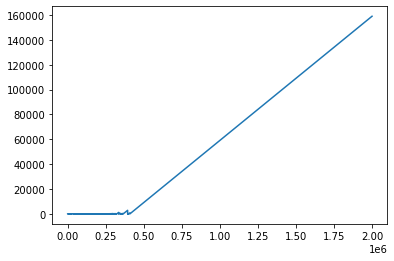

In [16]:
plt.plot(agent.train_rewards)

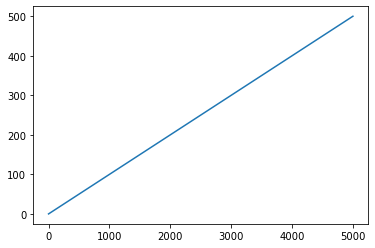

In [17]:
plt.plot(agent.test_rewards)